# **DCGAN on 11k Hands**

Hands Dataset: 11076 images
https://sites.google.com/view/11khands 

Facades Dataset: 3528 images
https://sites.google.com/site/zhexuutssjtu/projects/arch

### Setup environment

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import keras
import glob
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import IPython.display as display
import os
from PIL import Image
from tensorflow.keras import layers
import time
import imageio

Using TensorFlow backend.


In [0]:
# Configure tensorflow
AUTOTUNE = tf.data.experimental.AUTOTUNE
#tf.enable_eager_execution()
tf.random.set_seed(0)

In [0]:
%cd /content/drive/My Drive/CMPT419/

/content/drive/My Drive/CMPT419


## **1. Process Data**

In [0]:
#!unzip Hands.zip;
#!unzip arcDataset.zip;

In [0]:
# declare parameters
BUFFER_SIZE = 400
BATCH_SIZE = 128
IMG_WIDTH = 64
IMG_HEIGHT = 64

### Helper fucntions for fetching and displaying images

In [0]:
# define function for loading images file
# input: file path
# output: eager tensor of shape=(IMG_WIDTH, IMG_HEIGHT, 3) of dtype=float32
def load(image_file):
  img = tf.io.read_file(image_file)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  image = image[:, :, :]
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = (img - 127.5) / 127.5 # Normalize the image to [-1, 1]
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
# input: file path string
# output: decoded image
def process_path(file_path):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  print(img)
  img = decode_img(img)
  return img

In [0]:
# input: dataset
# output: shuffled and batched (size of BATCH_SIZE) dataset
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
def show_batch(image_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

### Executing processing

In [0]:
list_ds = tf.data.Dataset.list_files('Hands/*.jpg')

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
processed_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Tensor("ReadFile:0", shape=(), dtype=string)


In [0]:
filecache_ds = prepare_for_training(processed_ds, cache="./hands.tfcache")

In [0]:
# shuffle data
train_ds = prepare_for_training(processed_ds)
# create image batch
image_batch = next(iter(train_ds))

### Dataset Info

In [0]:
# Show size of dataset
images = list(glob.glob('Hands/*.jpg'))
image_count = len(images)
image_count

11076

In [0]:
num_batches = tf.data.experimental.cardinality(train_ds).numpy()
num_batches

87

In [0]:
# Print shape of images
for image in processed_ds.take(1):
  print("Image shape: ", image.numpy().shape)

Image shape:  (64, 64, 3)


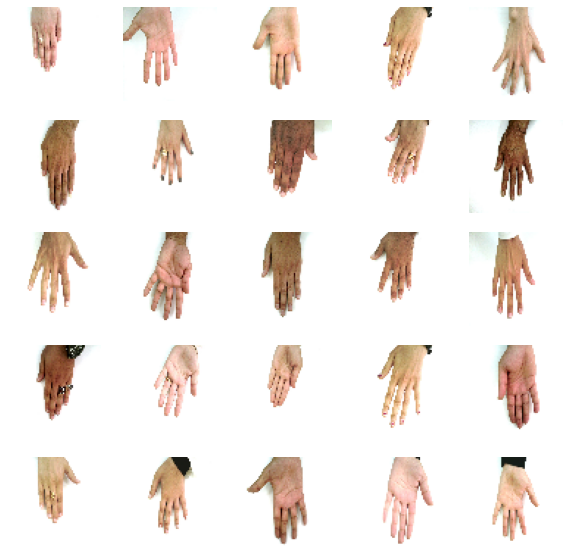

In [0]:
show_batch(image_batch.numpy())

## **2. Create Models**

Adapted from:

https://www.tensorflow.org/tutorials/generative/dcgan

https://machinelearningmastery.com/how-to-get-started-with-generative-adversarial-networks-7-day-mini-course/

Convolutional Math:
http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html

### Generator

Dense layer: densely connected CNN

Upsample with transpose convolution layers. 

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    # project and reshape
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024) # Note: None is the batch size

    # upsample to 8x8x512
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

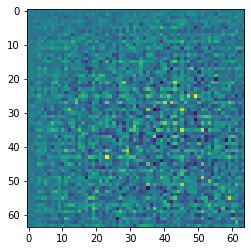

In [0]:
# Generate image from untrained generator
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0])

### Discriminator

Downsample with convolution layers.

Layers adapted from: 
http://bamos.github.io/2016/08/09/deep-completion/

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    # downsample to 32x32x64
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3)) # prevents overfitting
    
    # downsample to 16x16x128
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 16, 16, 128)

    # downsample to 8x8x256
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # downsample to 4x4xx512
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # output to 1x1x1
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[5.289193e-05]], shape=(1, 1), dtype=float32)


## **3. Define Loss and Optimizers**


Binary cross entropy is essentially the difference in the predicted probability of n and the actual probability of n.

Minimizing cross entropy is equivalent to minimizing the negative log likelihood of our data, which is a direct measure of the predictive power of our model.

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers

Adam stochastic gradient descent computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Checkpoints


In [0]:
# Save checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(step=tf.Variable(1),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
manager = tf.train.CheckpointManager(checkpoint, './training_checkpoints', max_to_keep=3)

## **4. Training**


In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images):
    # random noise for generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      # calculate loss
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Training function

Times execution and displays the progress of the models by generating images from the seed. It saves a checkpoint every 5 epochs. 

In [0]:
def train(dataset, epochs,training):

  train_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    batch_count = 0;

    for image_batch in dataset:
      train_step(image_batch)
      batch_count += 1
      display.clear_output(wait=True)
      print('Batches processed {0}'.format(batch_count))
      print('Epoch: {0}'.format(epoch + 1))

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             training)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  end = time.time()
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           training)
  hours, rem = divmod(end-train_start, 3600)
  minutes, seconds = divmod(rem, 60)
  print ('Time for training is {} hours and {} mins.'.format(int(hours),int(minutes)))

### Restoring checkpoints and resuming training

In [0]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
def restore_train(dataset, epochs,training,offset):
  
  checkpoint.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    display.clear_output(wait=True)
    print("Restored from {} ending at step {}".format(manager.latest_checkpoint,int(checkpoint.step)))
  else:
    display.clear_output(wait=True)
    print("Initializing from scratch.")

  train_start = time.time()
  for epoch in range(epochs):
    epoch+=offset
    start = time.time()
    batch_count = 0;

    for image_batch in dataset:
      train_step(image_batch)
      batch_count += 1
      display.clear_output(wait=True)
      print('Batches processed {0}'.format(batch_count))
      print('Epoch: {0}'.format(epoch + 1))

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             training)

    # Save the model every 15 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  end = time.time()
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           training)
  hours, rem = divmod(end-train_start, 3600)
  minutes, seconds = divmod(rem, 60)
  print ('Time for training is {} hours and {} mins.'.format(int(hours),int(minutes)))

### Helper functions to generate images and gifs

In [0]:
def generate_and_save_images(model, epoch, test_input,training):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i])# * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('train{:02d}/image_at_epoch_{:04d}.png'.format(training,epoch))
  plt.show()

In [0]:
def generate_gif(training):
  anim_file = 'train{:02}/dcgan{:02d}.gif'.format(training,training)

  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('train{:02}/image*.png'.format(training))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
      frame = 2*(i**0.25)
      if round(frame) > round(last):
        last = frame
      else:
        continue
      image = imageio.imread(filename)
      writer.append_data(image)
      image = imageio.imread(filename)
      writer.append_data(image)

### Execution

In [0]:
training=8
#os.mkdir('train{:02d}'.format(training))
train(train_ds, EPOCHS,training)
generate_gifs(training)

Batches processed 39
Epoch: 10


In [0]:
training=8
restore_train(train_ds, EPOCHS, training, 5)
generate_gifs(training)

In [0]:
generator.summary()

### JavaScript Functions to avoid timeout

In [0]:
function ClickConnect(){
    console.log('Working.')
    document.querySelector("colab-toolbar-button").click() 
}

// Get the Interval ID 25 mins
var setInterval_ID = setInterval(ClickConnect, 1500000);

// Set timeout to call stop_interval function after 12 seconds
//setTimeout(stop_interval, 12000);

function stop_interval(){
  	clearInterval(setInterval_ID);
}


### Blanks
